In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from __future__ import annotations
import numpy as np
import scipy

from mflex.simulate.simulate_boundary import dalmatian

from mhsflex.field2d import Field2dData
from mhsflex.field3d import Field3dData, calculate_magfield
from mhsflex.vis import plot, plot_plasma_parameters, show_poles, show_footpoints
from mhsflex.metrics import compare_field3d

from matplotlib import rc, colors
import matplotlib.pyplot as plt
from scipy.io import readsav


rc("font", **{"family": "serif", "serif": ["Times"]})
rc("text", usetex=True)

c4 = (1.000, 0.224, 0.376)
c1 = (0.439, 0.788, 1.000)
c3 = "black"
c2 = (0.420, 0.502, 1.000)

cmap = colors.LinearSegmentedColormap.from_list(
    "cmap",
    (
        (0.000, (0.000, 0.000, 0.000)),
        (0.500, (0.659, 0.659, 0.659)),
        (1.000, (1.000, 1.000, 1.000)),
    ),
)

cmap2 = colors.LinearSegmentedColormap.from_list(
    "cmap2", ((0.000, (0.984, 1.000, 0.000)), (1.000, (1.000, 0.988, 0.761)))
)

/Users/lilli/Library/Caches/pypoetry/virtualenvs/mflex-cNoQEf_u-py3.12/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
path = "/Users/lilli/Desktop/mflex/data/RMHD_boundary_data.sav"

data = readsav(path, python_dict=True, verbose=True)

--------------------------------------------------
Date: Tue Sep  6 15:18:26 2022
User: xszhu
Host: HR30
--------------------------------------------------
Format: 9
Architecture: x86_64
Operating System: linux
IDL Version: 7.1.1
--------------------------------------------------
Successfully read 10 records of which:
 - 6 are of type VARIABLE
 - 1 are of type VERSION
 - 1 are of type TIMESTAMP
 - 1 are of type NOTICE
--------------------------------------------------
Available variables:
 - b2dx [<class 'numpy.ndarray'>]
 - b2dy [<class 'numpy.ndarray'>]
 - b2dz [<class 'numpy.ndarray'>]
 - info_unit [<class 'bytes'>]
 - info_pixel [<class 'bytes'>]
 - info_array [<class 'bytes'>]
--------------------------------------------------


In [4]:
data_bz = data["b2dz"]  
data_bx = data["b2dx"]  
data_by = data["b2dy"]  

nresol_x = data_bz.shape[1]
nresol_y = data_bz.shape[0]

pixelsize_z_Mm = 64.0 * 10**-3  # Convert pixelsize from km into Mm
pixelsize_x_Mm = 192.0 * 10**-3
pixelsize_y_Mm = 192.0 * 10**-3

xmin = np.float64(0.0)  # Minimum value of x in data length scale, not in Mm
ymin = np.float64(0.0)  # Minimum value of y in data length scale, not in Mm
zmin = np.float64(0.0)  # Minimum value of z in data length scale, not in Mm

xmax_Mm = nresol_x * pixelsize_x_Mm
ymax_Mm = nresol_y * pixelsize_y_Mm
zmax_Mm = 41.6

nresol_z = int(np.floor(zmax_Mm / pixelsize_z_Mm))

z0 = 2000.0 * 10**-3

deltaz = z0 / 10

nf_max = min(nresol_x, nresol_y)

print("xmax_Mm, ymax_Mm, zmax_Mm", xmax_Mm, ymax_Mm, zmax_Mm)
print("nresol_x, nresol_y, nresol_z", nresol_x, nresol_y, nresol_z)
print("pixelsize_x", pixelsize_x_Mm)
print("pixelsize_y", pixelsize_y_Mm)
print("pixelsize_z", pixelsize_z_Mm)

xmax_Mm, ymax_Mm, zmax_Mm 98.304 49.152 41.6
nresol_x, nresol_y, nresol_z 512 256 650
pixelsize_x 0.192
pixelsize_y 0.192
pixelsize_z 0.064


In [6]:
x_arr = np.arange(nresol_x) * (xmax_Mm - xmin) / (nresol_x - 1) + xmin
y_arr = np.arange(nresol_y) * (ymax_Mm - ymin) / (nresol_y - 1) + ymin
z_arr = np.arange(nresol_z) * (zmax_Mm - zmin) / (nresol_z - 1) + zmin
x_grid, y_grid = np.meshgrid(x_arr, y_arr)

In [7]:
data2d = Field2dData(nresol_x, nresol_y, nresol_z, nf_max, pixelsize_x_Mm, pixelsize_y_Mm, pixelsize_z_Mm, x_arr, y_arr, z_arr, data_bz)

In [ ]:
alpha = 0.004

length_scale = float(2.0)  # Normalising length scale for Seehafer

length_scale_x = 2.0 * nresol_x * pixelsize_x_Mm 
length_scale_y = 2.0 * nresol_y * pixelsize_y_Mm 

length_scale_x_norm = length_scale_x / length_scale
length_scale_y_norm = length_scale_y / length_scale

kx_arr = np.arange(nf_max) * np.pi / length_scale_x_norm  # [0:nf_max]
ky_arr = np.arange(nf_max) * np.pi / length_scale_y_norm  # [0:nf_max]
one_arr = 0.0 * np.arange(nf_max) + 1.0

ky_grid = np.outer(ky_arr, one_arr)  # [0:nf_max, 0:nf_max]
kx_grid = np.outer(one_arr, kx_arr)  # [0:nf_max, 0:nf_max]

# kx^2 + ky^2

k2_arr = np.outer(ky_arr**2, one_arr) + np.outer(one_arr, kx_arr**2)
k2_arr[0, 0] = (np.pi / length_scale_x_norm) ** 2 + (np.pi / length_scale_y_norm) ** 2


# Need k^2 > alpha^2/(1-2a) and k^2 > alpha^2

limit = (k2_arr - (2 * alpha) ** 2) / (2 * k2_arr)

print(limit.min())

In [8]:
folder = "/Users/lilli/Desktop/Thesis/ISSIRMHD"

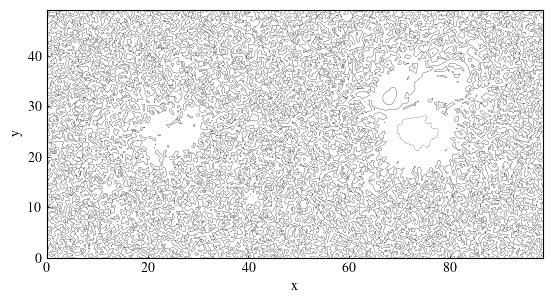

In [30]:
fig = plt.figure()
ax = fig.add_subplot(111)
CS = ax.contour(
    x_grid,
    y_grid,
    data2d.bz,
    2,
    colors="k",
    linewidths=0.2,
)
ax.set_xlabel("x")
ax.set_ylabel("y")
ax.set_box_aspect(ymax_Mm/xmax_Mm)
#ax.clabel(CS, fontsize=8, inline=True)
ax.tick_params(direction="in", length=2, width=0.5)
plotname = folder + "/contour.png"
plt.savefig(plotname, dpi=600, bbox_inches="tight", pad_inches=0.1)
plt.show()

In [ ]:
data3d = calculate_magfield(data2d, 0.46, 1.0, 0.004, z0, deltaz)
path2saveMHS3 = "/Users/lilli/Desktop/mflex/ISSIRMHD/MHS3"
data3d.save(path2saveMHS3)

In [ ]:
plot(data3d, 'angular', False, True, path=folder)
plot(data3d, 'side', False, True, path=folder)
plot(data3d, 'los', False, True, path=folder)

In [31]:
# data3dmhs2 = calculate_magfield(data2d, 0.3, 1.0, 0.01, z0, deltaz)

path2saveMHS2 = "/Users/lilli/Desktop/mflex/ISSIRMHD/MHS2"
# data3dmhs2.save(path2saveMHS2)

data3dmhs2 = Field3dData.load(path2saveMHS2)

TimeoutError: [Errno 60] Operation timed out

In [ ]:
# data3dmhs1 = calculate_magfield(data2d, 0.15, 1.0, 0.01, z0, deltaz)

path2saveMHS1 = "/Users/lilli/Desktop/mflex/ISSIRMHD/MHS1"
# data3dmhs1.save(path2saveMHS1)

data3dmhs1 = Field3dData.load(path2saveMHS1)

In [ ]:
# data3dpot = calculate_magfield(data2d, 0.0, 1.0, 0.0, z0, deltaz)

# path2savepot = "/Users/lilli/Desktop/mflex/ISSIRMHD/Potential"
# # data3dpot.save(path2savepot)

# data3dpot = Field3dData.load(path2savepot)

In [ ]:
# data3dlff = calculate_magfield(data2d, 0.0, 1.0 , 0.01, z0, deltaz)

path2saveLFF = "/Users/lilli/Desktop/mflex/ISSIRMHD/LFF"
# data3dlff.save(path2saveLFF)

data3dlff = Field3dData.load(path2saveLFF)

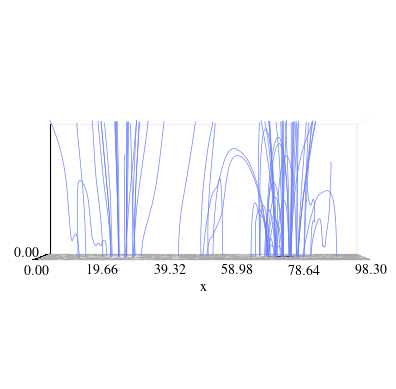

In [8]:
plot(data3dmhs2, 'side', False)

In [ ]:
fig = plt.figure()
ax = fig.add_subplot(111)
CS = ax.contour(
    x_grid,
    y_grid,
    data2d.bz,
    3,
    colors="k",
    linewidths=0.2,
)
ax.set_xlabel("x")
ax.set_ylabel("y")
#ax.clabel(CS, fontsize=5, inline=True)
ax.set_box_aspect(ymax_Mm/xmax_Mm)
ax.tick_params(direction="in", length=2, width=0.5)
plotname = folder + "/contour.png"
plt.savefig(plotname, dpi=600, bbox_inches="tight", pad_inches=0.1)
plt.show()

In [ ]:
fig = plt.figure()
ax = fig.add_subplot(111)
CS = ax.contour(
    x_grid,
    y_grid,
    data2d.bz,
    levels=np.array((-2000,-500, 500, 2000)),
    colors="k",
    linewidths=0.5,
)
ax.set_xlabel("x")
ax.set_ylabel("y")
ax.clabel(CS, fontsize=5, inline=True)
ax.set_box_aspect(ymax_Mm/xmax_Mm)
ax.tick_params(direction="in", length=2, width=0.5)
plotname = folder + "/contour2.png"
plt.savefig(plotname, dpi=600, bbox_inches="tight", pad_inches=0.1)
plt.show()

In [ ]:
show_poles(data3dmhs2)

In [ ]:
show_footpoints(data3dmhs2)

In [ ]:
plot(data3dlff, 'angular', False, True, path=folder)
plot(data3dlff, 'side', False, True, path=folder)
plot(data3dlff, 'los', False, True, path=folder)

In [ ]:
path3dref = "/Users/lilli/Desktop/mflex/data/RMHD_3D_data.sav"
data3dref = scipy.io.readsav(path3dref, python_dict=True, verbose=True)

print(data3dref["info_unit"])
print(data3dref["info_pixel"])
print(data3dref["info_array"])

bx_ref = data3dref["b3dx"]
by_ref = data3dref["b3dy"]
bz_ref = data3dref["b3dz"]

pres_3d = data3dref["p3d"] * 10**-1
den_3d = data3dref["d3d"] * 10**3

bx_rec = data3dmhs2.field[nresol_y : 2 * nresol_y, nresol_x : 2 * nresol_x, :, 1]
by_rec = data3dmhs2.field[nresol_y : 2 * nresol_y, nresol_x : 2 * nresol_x, :, 0]
bz_rec = data3dmhs2.field[nresol_y : 2 * nresol_y, nresol_x : 2 * nresol_x, :, 2]
print(bx_rec.shape)
print(by_rec.shape)
print(bz_rec.shape)

issi_bx = np.zeros_like(bx_rec)
issi_by = np.zeros_like(by_rec)
issi_bz = np.zeros_like(bz_rec)

for i in range(0, nresol_y):
    for j in range(0, nresol_x):
        for k in range(0, nresol_z):
            issi_bx[i, j, k] = bx_ref[k, i, j]
            issi_by[i, j, k] = by_ref[k, i, j]
            issi_bz[i, j, k] = bz_ref[k, i, j]

B_rec = np.array((by_rec, bx_rec, bz_rec))
B_ref = np.array((issi_by, issi_bx, issi_bz))

In [ ]:
from mhsflex.metrics import VecCorr, CauSchw, NormErr, MeanErr, MagEnergy

print(VecCorr(B_ref, B_rec))
print(CauSchw(B_ref, B_rec))
print(NormErr(B_ref, B_rec))
print(MeanErr(B_ref, B_rec))
print(MagEnergy(B_ref, B_rec))

print(VecCorr(B_ref, B_ref))
print(CauSchw(B_ref, B_ref))
print(NormErr(B_ref, B_ref))
print(MeanErr(B_ref, B_ref))
print(MagEnergy(B_ref, B_ref))

In [ ]:
B_ref_See = np.zeros_like(data3dmhs2.field)

for iz in range(0, nresol_z):
    for ix in range(0, nresol_x):
        for iy in range(0, nresol_y):
            for id in range(0, 3):
                B_ref_See[nresol_y + iy, nresol_x + ix, iz, id] = B_ref[id, iy, ix, iz]
                B_ref_See[nresol_y + iy, ix, iz, id] = -B_ref[
                    id, iy, nresol_x - 1 - ix, iz
                ]
                B_ref_See[iy, nresol_x + ix, iz, id] = -B_ref[
                    id, nresol_y - 1 - iy, ix, iz
                ]
                B_ref_See[iy, ix, iz, id] = B_ref[
                    id, nresol_y - 1 - iy, nresol_x - 1 - ix, iz
                ]

Data3dref = Field3dData(nresol_x, nresol_y, nresol_z, nf_max, x_arr, y_arr, z_arr, data3dmhs2.bz, B_ref_See, np.zeros_like(B_ref_See), 0, 0, 0, 0, 0, tanh=True)

In [ ]:
from mhsflex.metrics import field_div_metric

field_div_metric(Data3dref, data3dmhs2)

In [ ]:
temps = np.array((6000.0, 5500.0, 10000.0, 500000.0, 1000000.0, 1500000.0))  # Kelvin
heights = np.array((0.0, 0.5, 2.0, 2.2, 5.0, 100.0))

from mhsflex.field3d import bpressure_linear, bdensity_linear, btemp_linear, fpressure_linear, fdensity_linear

backtemp = btemp_linear(data3dmhs2, heights, temps)
backpres = bpressure_linear(data3dmhs2, heights, temps)
backden = bdensity_linear(data3dmhs2, heights, temps)

In [ ]:
fpres = fpressure_linear(data3dmhs2, heights, temps)
fden = fdensity_linear(data3dmhs2, heights, temps)

In [ ]:
pres_3d = data3dref["p3d"] * 10**-1 
den_3d = data3dref["d3d"] * 10**3 

In [ ]:
# plt.plot(
#     z_arr[0:650],
#     fpres[0, 0, 0:650],
#     linewidth=0.5,
#     color=c4,
#     label="Recreated pressure",
# )
# plt.plot(
#     z_arr[0:650],
#     pres_3d[0:650, 0, 0]* 10**-1 ,
#     linewidth=0.5,
#     color=c2,
#     #linestyle="dashed",
#     label="Reference pressure",
# )
for ix in range(0, nresol_x, 5):
    for iy in range(0, nresol_y, 5):
# for ix in range(nresol_x):
#     for iy in range(nresol_y):
        # plt.plot(
        #     z_arr[0:650], fpres[iy, ix, 0:650], linewidth=0.2, color=c4, alpha=0.5
        # )
        plt.plot(
            z_arr[0:650],
            pres_3d[0:650, iy, ix],
            linewidth=0.2,
            color=c2,
            #linestyle="dashed",
            alpha=0.5,
        )
plt.ylabel("$kg/(s^2 m)$")
plt.xlabel("z")
plt.legend(frameon=False)
plt.xlim([0,4])
plt.tick_params(direction="in", length=2, width=0.5)
plotname = folder + "/fpres_comp.png"
plt.savefig(plotname, dpi=600, bbox_inches="tight", pad_inches=0.1)
plt.show()

In [ ]:
for ix in range(0, nresol_x, 5):
    for iy in range(0, nresol_y, 5):
# for ix in range(nresol_x):
#     for iy in range(nresol_y):
        plt.plot(
            z_arr[0:650], fpres[iy, ix, 0:650], linewidth=0.2, color=c4, alpha=0.5
        )
        # plt.plot(
        #     z_arr[0:650],
        #     pres_3d[0:650, iy, ix],
        #     linewidth=0.2,
        #     color=c2,
        #     #linestyle="dashed",
        #     alpha=0.5,
        # )
plt.ylabel("$kg/(s^2 m)$")
plt.xlabel("z")
plt.legend(frameon=False)
plt.xlim([0,4])
plt.tick_params(direction="in", length=2, width=0.5)
plotname = folder + "/fpres_comp.png"
plt.savefig(plotname, dpi=600, bbox_inches="tight", pad_inches=0.1)
plt.show()

In [ ]:
# plt.plot(
#     z_arr[0:650],
#     fden[0, 0, 0:650],
#     linewidth=0.5,
#     color=c4,
#     label="Recreated density",
# )
# plt.plot(
#     z_arr[0:650],
#     den_3d[0:650, 0, 0],
#     linewidth=0.5,
#     color=c2,
#     #linestyle="dashed",
#     label="Reference density",
# )
for ix in range(0, nresol_x, 4):
    for iy in range(0, nresol_y, 4):
        # plt.plot(
        #     z_arr[0:650], fden[iy, ix, 0:650], linewidth=0.5, color=c4, #alpha=0.04
        # )
        plt.plot(
            z_arr[0:650],
            den_3d[0:650, iy, ix],
            linewidth=0.2,
            color=c2,
            #linestyle="dashed",
            alpha=0.5,
        )
plt.ylabel("$kg/m^3$")
plt.xlabel("z")
plt.legend(frameon=False)
plt.xlim([0,4])
plt.tick_params(direction="in", length=2, width=0.5)
plotname = folder + "/fden_comp.png"
plt.savefig(plotname, dpi=600, bbox_inches="tight", pad_inches=0.1)
plt.show()

In [ ]:
for ix in range(0, nresol_x, 4):
    for iy in range(0, nresol_y, 4):
        plt.plot(
            z_arr[0:650], fden[iy, ix, 0:650], linewidth=0.2, color=c4, alpha=0.5
        )
        # plt.plot(
        #     z_arr[0:650],
        #     den_3d[0:650, iy, ix],
        #     linewidth=0.2,
        #     color=c2,
        #     #linestyle="dashed",
        #     alpha=0.5,
        # )
plt.ylabel("$kg/m^3$")
plt.xlabel("z")
plt.legend(frameon=False)
plt.xlim([0,4])
plt.tick_params(direction="in", length=2, width=0.5)
plotname = folder + "/fden_comp.png"
plt.savefig(plotname, dpi=600, bbox_inches="tight", pad_inches=0.1)
plt.show()